# Core

> bioMONAI core functions


In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

## Imports

This section includes essential imports used throughout the core library, providing foundational tools for data handling, model training, and evaluation. Key imports cover areas such as data blocks, data loaders, custom loss functions, optimizers, callbacks, and logging. 


In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap

from torch import Tensor as torchTensor
from torch import tensor
from monai.data import MetaTensor
from monai.utils import set_determinism

import torch.nn.functional as F
from torch.nn.init import kaiming_normal_

from random import randint

from skimage import util
from skimage.data import cells3d

In [ ]:
#| export
from torch import squeeze as torchsqueeze, max as torchmax, from_numpy as torch_from_numpy, device as torch_device
from torch.cuda import is_available as is_cuda_available

In [ ]:
#| export
from collections.abc import MutableSequence
from typing import MutableSequence
    
from fastai.callback.core import Callback
from fastai.data.all import DataLoaders, Path, trainable_params, delegates, hasattrs, Path, List, L, typedispatch, Normalize
from fastai.optimizer import Adam, OptimWrapper, Optimizer
from fastai.vision.all import BypassNewMeta, DisplayedTransform, store_attr, DataBlock, Learner, ShowGraphCallback, CSVLogger, Any, minimum, steep, valley, slide, create_vision_model, create_timm_model, get_c, default_split, model_meta, ifnone, ClassificationInterpretation
from fastcore.script import risinstance

In [ ]:
show_doc(DataBlock)


---

[source](https://github.com/fastai/fastai/blob/master/fastai/data/block.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### DataBlock

>      DataBlock (blocks:list=None, dl_type:TfmdDL=None, getters:list=None,
>                 n_inp:int=None, item_tfms:list=None, batch_tfms:list=None,
>                 get_items=None, splitter=None, get_y=None, get_x=None)

*Generic container to quickly build `Datasets` and `DataLoaders`.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| blocks | list | None | One or more `TransformBlock`s |
| dl_type | TfmdDL | None | Task specific `TfmdDL`, defaults to `block`'s dl_type or`TfmdDL` |
| getters | list | None | Getter functions applied to results of `get_items` |
| n_inp | int | None | Number of inputs |
| item_tfms | list | None | `ItemTransform`s, applied on an item |
| batch_tfms | list | None | `Transform`s or `RandTransform`s, applied by batch |
| get_items | NoneType | None |  |
| splitter | NoneType | None |  |
| get_y | NoneType | None |  |
| get_x | NoneType | None |  |

The `DataBlock` class acts as a container for creating data processing pipelines, allowing easy customization of datasets and data loaders. It enables the definition of item transformations, batch transformations, and dataset split methods, streamlining data preprocessing and loading across various stages of model training.


In [ ]:
show_doc(DataLoaders)


---

[source](https://github.com/fastai/fastai/blob/master/fastai/data/core.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### DataLoaders

>      DataLoaders (*loaders, path:str|pathlib.Path='.', device=None)

*Basic wrapper around several `DataLoader`s.*

The `DataLoaders` class is a container for managing training and validation datasets. This class wraps one or more `DataLoader` instances, ensuring seamless data management and transfer across devices (CPU or GPU) for efficient training and evaluation.


In [ ]:
show_doc(Learner)


---

[source](https://github.com/fastai/fastai/blob/master/fastai/learner.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Learner



*Group together a `model`, some `dls` and a `loss_func` to handle training*

The `Learner` class is the main interface for training machine learning models, encapsulating the model, data, loss function, optimizer, and training metrics. It simplifies the training process by providing built-in functionality for model evaluation, hyperparameter tuning, and training loop customization, allowing you to focus on model optimization.


In [ ]:
show_doc(ShowGraphCallback)


---

[source](https://github.com/fastai/fastai/blob/master/fastai/callback/progress.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### ShowGraphCallback

>      ShowGraphCallback (after_create=None, before_fit=None, before_epoch=None,
>                         before_train=None, before_batch=None, after_pred=None,
>                         after_loss=None, before_backward=None,
>                         after_cancel_backward=None, after_backward=None,
>                         before_step=None, after_cancel_step=None,
>                         after_step=None, after_cancel_batch=None,
>                         after_batch=None, after_cancel_train=None,
>                         after_train=None, before_validate=None,
>                         after_cancel_validate=None, after_validate=None,
>                         after_cancel_epoch=None, after_epoch=None,
>                         after_cancel_fit=None, after_fit=None)

*Update a graph of training and validation loss*

The `ShowGraphCallback` is a convenient callback for visualizing training progress. By plotting the training and validation loss, it helps users monitor convergence and performance, making it easy to assess if the model requires adjustments in learning rate, architecture, or data handling.


In [ ]:
show_doc(CSVLogger)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/callback/progress.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### CSVLogger

>      CSVLogger (fname='history.csv', append=False)

*Log the results displayed in `learn.path/fname`*

The `CSVLogger` is a tool for logging model training metrics to a CSV file, offering a permanent record of training history. This feature is especially useful for long-term experiments and fine-tuning, allowing you to track and analyze model performance over time.


In [ ]:
show_doc(cells3d)

---

### cells3d

>      cells3d ()

*3D fluorescence microscopy image of cells.

The returned data is a 3D multichannel array with dimensions provided in
``(z, c, y, x)`` order. Each voxel has a size of ``(0.29 0.26 0.26)``
micrometer. Channel 0 contains cell membranes, channel 1 contains nuclei.*

The `cells3d` function returns a sample 3D fluorescence microscopy image. This is a valuable test image for demonstration and analysis, consisting of both cell membrane and nucleus channels. It can serve as a default dataset for evaluating and benchmarking new models and transformations.


## Engine

The engine module provides advanced functionalities for model training, including configurable training loops and evaluation functions tailored for bioinformatics applications.


In [ ]:
#| export
class fastTrainer(Learner):
    """
    A custom implementation of the FastAI Learner class for training models in bioinformatics applications.

    """
    
    def __init__(self, 
                 dataloaders: DataLoaders, # The DataLoader objects containing training and validation datasets.
                 model: callable, # A callable model that will be trained on the dataset.
                 loss_fn: Any | None = None, # The loss function to optimize during training. If None, defaults to a suitable default.
                 optimizer: Optimizer | OptimWrapper = Adam, # The optimizer function to use. Defaults to Adam if not specified.
                 lr: float | slice = 1e-3, # Learning rate for the optimizer. Can be a float or a slice object for learning rate scheduling.
                 splitter: callable = trainable_params, # 
                 callbacks: Callback | MutableSequence | None = None, # A callable that determines which parameters of the model should be updated during training.
                 metrics: Any | MutableSequence | None = None, # Optional list of callback functions to customize training behavior.
                 csv_log: bool = False, # Metrics to evaluate the performance of the model during training.
                 show_graph: bool = True, # Whether to log training history to a CSV file. If True, logs will be appended to 'history.csv'.
                 show_summary: bool = False, # The base directory where models are saved or loaded from. Defaults to None.
                 find_lr: bool = False, # Subdirectory within the base path where trained models are stored. Default is 'models'.
                 find_lr_fn = valley, # Weight decay factor for optimization. Defaults to None.
                 path: str | Path | None = None, # Whether to apply weight decay to batch normalization and bias parameters.
                 model_dir: str | Path = 'models', # Whether to update the batch normalization statistics during training.
                 wd: float | int | None = None, 
                 wd_bn_bias: bool = False, 
                 train_bn: bool = True, 
                 moms: tuple = (0.95,0.85,0.95), # Tuple of tuples representing the momentum values for different layers in the model. Defaults to FastAI's default settings if not specified.
                 default_cbs: bool = True, # Automatically include default callbacks such as ShowGraphCallback and CSVLogger.
                 ):
        cbs = callbacks if callbacks is not None else []  # Ensure cbs is a list
        if default_cbs:
            if show_graph:
                cbs.append(ShowGraphCallback())
            if csv_log:
                cbs.append(CSVLogger(fname='history.csv', append=False))
        
        super().__init__(dataloaders, model, loss_fn, optimizer, lr, splitter, cbs, metrics, path, model_dir, wd, wd_bn_bias, train_bn, moms)
        
        if show_summary:
                print(self.summary())
        if find_lr:
                lr = self.lr_find(suggest_funcs=find_lr_fn)
                self.lr = float('%.1g'%(lr))
                print('Inferred learning rate: ', self.lr)

In [ ]:
#| export
def _add_norm(dls, meta, pretrained, n_in=3):
    if not pretrained: return
    stats = meta.get('stats')
    if stats is None: return
    if n_in != len(stats[0]): return
    if not dls.after_batch.fs.filter(risinstance(Normalize)):
        dls.add_tfms([Normalize.from_stats(*stats)],'after_batch')

def _timm_norm(dls, cfg, pretrained, n_in=3):
    if not pretrained: return
    if n_in != len(cfg['mean']): return
    if not dls.after_batch.fs.filter(risinstance(Normalize)):
        tfm = Normalize.from_stats(cfg['mean'],cfg['std'])
        dls.add_tfms([tfm],'after_batch')

In [ ]:
#| export
@delegates(create_vision_model)
def visionTrainer(  dataloaders: DataLoaders, # The DataLoader objects containing training and validation datasets.
                    model: callable, # A callable model that will be trained on the dataset.
                    normalize=True, 
                    n_out=None, 
                    pretrained=True, 
                    weights=None,
                    # Trainer args
                    loss_fn: Any | None = None, # The loss function to optimize during training. If None, defaults to a suitable default.
                    optimizer: Optimizer | OptimWrapper = Adam, # The optimizer function to use. Defaults to Adam if not specified.
                    lr: float | slice = 1e-3, # Learning rate for the optimizer. Can be a float or a slice object for learning rate scheduling.
                    splitter: callable = trainable_params, # 
                    callbacks: Callback | MutableSequence | None = None, # A callable that determines which parameters of the model should be updated during training.
                    metrics: Any | MutableSequence | None = None, # Optional list of callback functions to customize training behavior.
                    csv_log: bool = False, # Metrics to evaluate the performance of the model during training.
                    show_graph: bool = True, # Whether to log training history to a CSV file. If True, logs will be appended to 'history.csv'.
                    show_summary: bool = False, # The base directory where models are saved or loaded from. Defaults to None.
                    find_lr: bool = False, # Subdirectory within the base path where trained models are stored. Default is 'models'.
                    find_lr_fn = valley, # Weight decay factor for optimization. Defaults to None.
                    path: str | Path | None = None, # Whether to apply weight decay to batch normalization and bias parameters.
                    model_dir: str | Path = 'models', # Whether to update the batch normalization statistics during training.
                    wd: float | int | None = None, 
                    wd_bn_bias: bool = False, 
                    train_bn: bool = True, 
                    moms: tuple = (0.95,0.85,0.95), # Tuple of tuples representing the momentum values for different layers in the model. Defaults to FastAI's default settings if not specified.
                    default_cbs: bool = True, # Automatically include default callbacks such as ShowGraphCallback and CSVLogger.
                    # model & head args
                    cut=None, 
                    init=kaiming_normal_, 
                    custom_head=None, 
                    concat_pool=True, 
                    pool=True,
                    lin_ftrs=None, 
                    ps=0.5, 
                    first_bn=True, 
                    bn_final=False, 
                    lin_first=False, 
                    y_range=None, 
                    **kwargs):
    "Build a vision trainer from `dataloaders` and `model`"
    if n_out is None: n_out = get_c(dataloaders)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dataloaders.c` or pass `n_out`"
    meta = model_meta.get(model, {'cut':cut, 'split':default_split})
    model_args = dict(init=init, custom_head=custom_head, concat_pool=concat_pool, pool=pool, lin_ftrs=lin_ftrs, ps=ps,
                      first_bn=first_bn, bn_final=bn_final, lin_first=lin_first, y_range=y_range, **kwargs)
    n_in = kwargs['n_in'] if 'n_in' in kwargs else 3
    if isinstance(model, str):
        model,cfg = create_timm_model(model, n_out, default_split, pretrained, **model_args)
        if normalize: _timm_norm(dataloaders, cfg, pretrained, n_in)
    else:
        if normalize: _add_norm(dataloaders, meta, pretrained, n_in)
        model = create_vision_model(model, n_out, pretrained=pretrained, weights=weights, **model_args)

    splitter = ifnone(splitter, meta['split'])
    trainer = fastTrainer(dataloaders, model, loss_fn=loss_fn, optimizer=optimizer, lr=lr, splitter=splitter, callbacks=callbacks, csv_log=csv_log, 
                        show_graph=show_graph, show_summary=show_summary, find_lr=find_lr, find_lr_fn=find_lr_fn, metrics=metrics, path=path, 
                        model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms, default_cbs=default_cbs)
    if pretrained: trainer.freeze()
    # keep track of args for loggers
    store_attr('model,normalize,n_out,pretrained', self=trainer, **kwargs)
    return trainer

## Evaluation

In [ ]:
#| export
def compute_losses(predictions, targets, loss_fn):
    """
    Compute the loss for each prediction-target pair.
    """
    return [loss_fn(p.unsqueeze(0), t.unsqueeze(0)).item() for p, t in zip(predictions, targets)]


def compute_metric(predictions, targets, metric_fn):
    """
    Compute the metric for each prediction-target pair.
    Handles cases where metric_fn has or does not have a 'func' attribute.
    """
    # Get the actual function to call (either metric_fn.func or metric_fn itself)
    metric_func = getattr(metric_fn, 'func', metric_fn)
    
    return [metric_func(p.unsqueeze(0), t.unsqueeze(0)).item() for p, t in zip(predictions, targets)]


def calculate_statistics(data):
    """
    Calculate key statistics for the data.
    """
    return {
        "Mean": np.mean(data),
        "Median": np.median(data),
        "Standard Deviation": np.std(data),
        "Min": np.min(data),
        "Max": np.max(data),
        "Q1": np.percentile(data, 25),
        "Q3": np.percentile(data, 75),
    }


def format_sig(value):
    """
    Format numbers with two significant digits.
    """
    if value == 0:
        return "0"
    elif abs(value) < 0.01 or abs(value) > 100:
        return f"{value:.2e}"  # 2 significant digits in scientific notation
    else:
        return f"{value:.2g}"  # Standard notation with 2 significant figures


def plot_histogram_and_kde(data, stats, bw_method=0.3, fn_name=''):
    """
    Plot the histogram and KDE of the data with key statistics marked.
    """
    kde = gaussian_kde(data, bw_method=bw_method)
    x = np.linspace(min(data), max(data), 1000)
    y = kde(x)

    gauss_color = 'lightslategrey'
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=30, density=True, color='darkgray', edgecolor='black', alpha=0.5)
    plt.plot(x, y, color=gauss_color, lw=2)
    plt.fill_between(x, y, color=gauss_color, alpha=0.3)

    # Add vertical lines for key statistics with formatted significant digits
    plt.axvline(stats["Mean"], color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {format_sig(stats["Mean"])}')
    plt.axvline(stats["Median"], color='steelblue', linestyle='--', linewidth=1.5, label=f'Median: {format_sig(stats["Median"])}')
    plt.axvline(stats["Q1"], color='purple', linestyle=':', linewidth=1.5, label=f'Q1: {format_sig(stats["Q1"])}')
    plt.axvline(stats["Q3"], color='purple', linestyle=':', linewidth=1.5, label=f'Q3: {format_sig(stats["Q3"])}')

    # Display min, max, std deviation as text on the plot
    plt.text(stats["Mean"] + stats["Standard Deviation"], 0.1, f'Std Dev: {format_sig(stats["Standard Deviation"])}', color='black', fontsize=10)
    plt.text(stats["Min"], 0.02, f'Min: {format_sig(stats["Min"])}', color='black', fontsize=10, ha='center')
    plt.text(stats["Max"], 0.02, f'Max: {format_sig(stats["Max"])}', color='black', fontsize=10, ha='center')

    # Add loss function name to the title
    plt.title(f"Combined Histogram and KDE with Statistics\n{fn_name}")
    plt.xlabel("Loss Value")
    plt.ylabel("Density")
    plt.legend()
    # plt.grid(True)
    plt.show()


def display_statistics_table(stats, fn_name='', as_dataframe=True):
    """
    Display a table of the key statistics.
    """
    if as_dataframe:
        # Convert statistics to a DataFrame and display
        df = pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])
        df.index.name = f"{fn_name}"
        display(df)
    else:
        fig, ax = plt.subplots(figsize=(5, 2))
        ax.axis("off")
        
        # Header title row
        table_data = [[f"{fn_name}", ""]]
        table_data += [[key, format_sig(value)] for key, value in stats.items()]
        
        table = ax.table(cellText=table_data, colLabels=["Statistic", "Value"], cellLoc="center", loc="center")
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)
        
        # Style for header row
        header = table[0, 0]
        header.set_fontsize(12)
        header.set_text_props(weight="bold")
        plt.show()

In [ ]:
from numpy.random import standard_normal

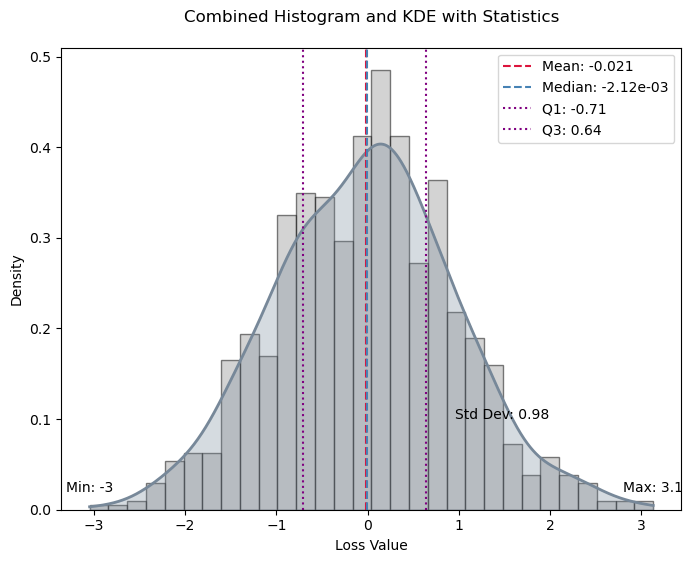

In [ ]:
a = standard_normal(1000)

stats = calculate_statistics(a)

plot_histogram_and_kde(a, stats)

In [ ]:
#| export
# Retrieve the 'coolwarm' colormap
coolwarm = plt.get_cmap('coolwarm')
# Create a new colormap using only the warm colors
warm_cmap = LinearSegmentedColormap.from_list('warm_coolwarm', coolwarm(np.linspace(0.5, 1, coolwarm.N // 2)))

In [ ]:
#| export 
def evaluate_model(trainer,                                 # The model trainer object with a get_preds method.
                   test_data:DataLoaders=None,              # DataLoader containing test data.
                   loss=None,                               # Loss function to evaluate prediction-target pairs.
                   metrics=None,                            # Single metric or a list of metrics to evaluate. 
                   bw_method=0.3,                           # Bandwidth method for KDE. 
                   show_graph=True,                         # Boolean flag to show the histogram and KDE plot.
                   show_table=True,                         # Boolean flag to show the statistics table.
                   show_results=True,                       # Boolean flag to show model results on test data. 
                   as_dataframe=True,                       # Boolean flag to display table as a DataFrame. 
                   cmap='magma',                            # Colormap for visualization.
                   ):
    """
    Calculate and optionally plot the distribution of loss values from predictions
    made by the trainer on test data, with an optional table of key statistics.
    """
    out = dict()
    
    if loss is None:
        loss = trainer.loss_func
        
    if test_data is None:
        p, t = trainer.get_preds()
        # Show results for test data
        if show_results:
            trainer.show_results(cmap=cmap)
    else:
        p, t = trainer.get_preds(dl=test_data)
        # Show results for test data
        if show_results:
            trainer.show_results(dl=test_data, cmap=cmap)

    # Calculate loss for each prediction-target pair
    losses = compute_losses(p, t, loss)
    loss_stats = calculate_statistics(losses)
    loss_name = loss.__class__.__name__  # Get loss function name
    out[loss_name] = losses    
    if show_graph:
        plot_histogram_and_kde(losses, loss_stats, bw_method, loss_name)
    if show_table:
        display_statistics_table(loss_stats, loss_name, as_dataframe=as_dataframe)
            
    if metrics is not None:
            if not isinstance(metrics, list):
                metrics = [metrics]
            # Loop through each metric
            for metric in metrics:
                # Calculate metric values for each prediction-target pair
                metric_values = compute_metric(p, t, metric)
                metric_stats = calculate_statistics(metric_values)         
                # Get the name of the metric function
                metric_name = getattr(metric, 'func', metric).__name__  # Support AvgMetric or regular functions                
                out[metric_name] = metric_values       
                if show_graph:
                    plot_histogram_and_kde(metric_values, metric_stats, bw_method, metric_name)
                if show_table:
                    display_statistics_table(metric_stats, metric_name, as_dataframe=as_dataframe)

    return out


In [ ]:
#| export
def evaluate_classification_model(trainer:Learner,              # The trained model (learner) to evaluate.
                                  test_data:DataLoaders=None,   # DataLoader with test data for evaluation. If None, the validation dataset is used.
                                  loss_fn=None,                 # Loss function used in the model for ClassificationInterpretation. If None, the loss function is loaded from trainer.
                                  most_confused_n:int=1,        # Number of most confused class pairs to display. 
                                  normalize:bool=True,          # Whether to normalize the confusion matrix.
                                  metrics=None,                 # Single metric or a list of metrics to evaluate. 
                                  bw_method=0.3,                # Bandwidth method for KDE. 
                                  show_graph=True,              # Boolean flag to show the histogram and KDE plot.
                                  show_table=True,              # Boolean flag to show the statistics table.
                                  show_results=True,            # Boolean flag to show model results on test data. 
                                  as_dataframe=True,            # Boolean flag to display table as a DataFrame. 
                                  cmap=warm_cmap,             # Color map for the confusion matrix plot. 
                                  ):
    """
    Evaluates a classification model by displaying results, confusion matrix, and most confused classes.
    """
    out = dict()
    
    if loss_fn is None:
            loss_fn = trainer.loss_func
    
    # Interpret the results on test data
    if test_data is None:
        class_int = ClassificationInterpretation.from_learner(trainer)
        p, t = trainer.get_preds()
        # Show results for test data
        if show_results:
            trainer.show_results()
    else:
        class_int = ClassificationInterpretation(trainer, test_data, loss_fn)
        p, t = trainer.get_preds(dl=test_data)
        # Show results for test data
        if show_results:
            trainer.show_results(dl=test_data)
    
    # Plot the confusion matrix
    class_int.plot_confusion_matrix(normalize=normalize, cmap=cmap)
    
    # Print Classification report
    class_int.print_classification_report()
    
    # Show the most confused classes
    print("\nMost Confused Classes:")
    print(class_int.most_confused(most_confused_n))

    # Calculate loss for each prediction-target pair
    losses = compute_losses(p, t, loss_fn)
    loss_stats = calculate_statistics(losses)
    loss_name = loss_fn.__class__.__name__  # Get loss function name
    out[loss_name] = losses
    if show_graph:
        plot_histogram_and_kde(losses, loss_stats, bw_method, loss_name)
    if show_table:
        display_statistics_table(loss_stats, loss_name, as_dataframe=as_dataframe)
            
    if metrics is not None:
            if not isinstance(metrics, list):
                metrics = [metrics]
            # Loop through each metric
            for metric in metrics:
                # Calculate metric values for each prediction-target pair
                metric_values = compute_metric(p, t, metric)
                metric_stats = calculate_statistics(metric_values)                
                # Get the name of the metric function
                metric_name = getattr(metric, 'func', metric).__name__  # Support AvgMetric or regular functions 
                out[metric_name] = metric_values                      
                if show_graph:
                    plot_histogram_and_kde(metric_values, metric_stats, bw_method, metric_name)
                if show_table:
                    display_statistics_table(metric_stats, metric_name, as_dataframe=as_dataframe)
    
    return out


## Utils


The utils module contains helper functions and classes to facilitate data manipulation, model setup, and training. These utilities add flexibility and convenience, supporting rapid experimentation and efficient data handling.


In [ ]:
#| export
def attributesFromDict(d):
    """
    The `attributesFromDict` function simplifies the conversion of dictionary keys and values into object attributes, allowing dynamic attribute creation for configuration objects. This utility is handy for initializing model or dataset configurations directly from dictionaries, improving code readability and maintainability.
    """
    self = d.pop('self')
    for n, v in d.items():
        setattr(self, n, v)

In [ ]:
#| export
def get_device():
    return torch_device("cuda" if is_cuda_available() else "cpu")

In [ ]:
#| export
def img2float(image, force_copy=False):
    return util.img_as_float(image, force_copy=force_copy)

In [ ]:
#| export
def img2Tensor(image):
    return torchTensor(img2float(image))

---

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()